# Exploring WAV files

## Decode standard compressed formats to `.wav`

In [1]:
import sys, os, wave, contextlib, audioread
import numpy as np

ModuleNotFoundError: No module named 'audioread'

Here's how to create a `.wav` file from (say) a `.mp3` file using the `audioread` library

In [15]:
# This is from https://github.com/beetbox/audioread/blob/master/decode.py

def decode(filename):
    filename = os.path.abspath(os.path.expanduser(filename))
    if not os.path.exists(filename):
        print("File not found.", file=sys.stderr)
        sys.exit(1)

    try:
        with audioread.audio_open(filename) as f:
            print('Input file: %i channels at %i Hz; %.1f seconds.' %
                  (f.channels, f.samplerate, f.duration),
                  file=sys.stderr)
            print('Backend:', str(type(f).__module__).split('.')[1],
                  file=sys.stderr)

            with contextlib.closing(wave.open(filename + '.wav', 'w')) as of:
                of.setnchannels(f.channels)
                of.setframerate(f.samplerate)
                of.setsampwidth(2)

                for buf in f:
                    of.writeframes(buf)

    except audioread.DecodeError:
        print("File could not be decoded.", file=sys.stderr)
        sys.exit(1)


In [16]:
decode("example.mp3")

Input file: 2 channels at 44100 Hz; 9.9 seconds.
Backend: macca


In [158]:
import IPython.display as ipd
ipd.Audio('example.mp3.wav')

## The WAV format

Use the `wave` module to read the raw bytes

In [ ]:
wav_file = "example.mp3.wav"

In [107]:
wav_file = os.path.abspath(os.path.expanduser(wav_file))
with wave.open(wav_file, mode=None) as f:
    print(f.getparams())
    frames = f.readframes(16) # Get the first 16 frames

_wave_params(nchannels=2, sampwidth=2, framerate=44100, nframes=437919, comptype='NONE', compname='not compressed')


Convert the bytes to integers. `sampwidth=2` indicates two bytes for each value i.e. 16 bit encoding. `nchannels=2` corresponds to stereo.

In [133]:
vals = np.array([], dtype=np.int16)
for idx in range(len(frames) // 4):
    vals = np.append(vals, int.from_bytes(frames[2*idx:2*idx+2], byteorder='little', signed=True))

In [137]:
vals.reshape([-1,2])

array([[-1,  0],
       [ 1, -2],
       [ 0,  2],
       [-1, -1],
       [ 1,  0],
       [-1,  1],
       [ 0, -2],
       [ 0,  2]])

Note that `int.from_bytes` returns `int64` by default 

In [138]:
vals.dtype

dtype('int64')

## Read and decode to numpy array using `scipy.io.wavfile`

This is more direct

In [42]:
from scipy.io import wavfile

In [143]:
_, waveform = wavfile.read(wav_file)

In [144]:
waveform[:8]

array([[-1,  0],
       [ 1, -2],
       [ 0,  2],
       [-1, -1],
       [ 1,  0],
       [-1,  1],
       [ 0, -2],
       [ 0,  2]], dtype=int16)

Two (stereo) channels, `int16` values

In [157]:
waveform.shape

(437919, 2)

Visualize

In [140]:
import matplotlib.pyplot as plt

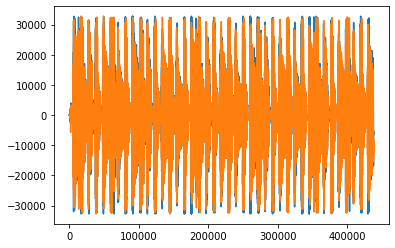

In [145]:
plt.plot(waveform)

Zoom in

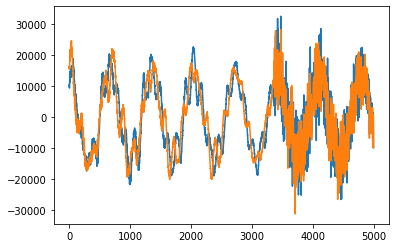

In [155]:
plt.plot(waveform[10000:15000,:])

## WAV files in TensorFlow

This can be done directly in TensorFlow...

In [159]:
import tensorflow as tf

In [161]:
file_string = tf.io.read_file(wav_file)

In [162]:
wav_tensor = tf.audio.decode_wav(file_string)

In [170]:
wav_tensor

DecodeWav(audio=<tf.Tensor: id=5, shape=(437919, 2), dtype=float32, numpy=
array([[-3.0517578e-05,  0.0000000e+00],
       [ 3.0517578e-05, -6.1035156e-05],
       [ 0.0000000e+00,  6.1035156e-05],
       ...,
       [-1.6644287e-01, -2.7993774e-01],
       [-1.9390869e-01, -3.1317139e-01],
       [-1.6375732e-01, -2.5942993e-01]], dtype=float32)>, sample_rate=<tf.Tensor: id=6, shape=(), dtype=int32, numpy=44100>)

Note that this is `float32` scaled from -32768 to 32767 to between -1.0 and +1.0. Then an integer value -1 becomes $-1/2^{15}=-3.0517578\times 10^{-5}$

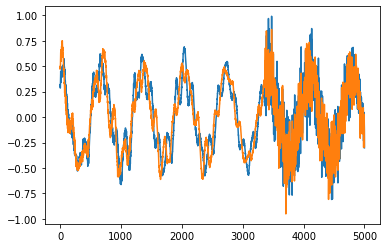

In [173]:
plt.plot(wav_tensor.audio[10000:15000,:])

__TODO__ converting to TFRecords. Is this necessary? See [this guide](https://www.tensorflow.org/guide/performance/datasets?hl=en) for more on data pipeline

## WAV files in PyTorch

Using the `pytorchaudio` module

In [4]:
import torchaudio
import matplotlib.pyplot as plt

Can load mp3 directly

Shape of waveform: torch.Size([2, 440064])
Sample rate of waveform: 44100


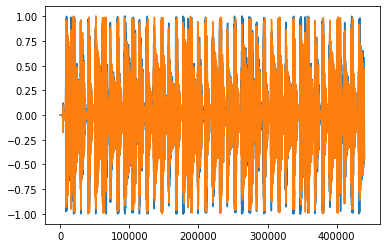

In [5]:
filename = "example.mp3"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

Shape of spectrogram: torch.Size([2, 201, 2201])


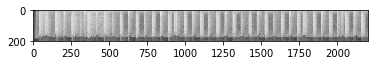

In [6]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

Resampling

Shape of transformed waveform: torch.Size([1, 44007])


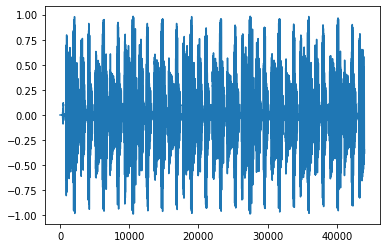

In [7]:
new_sample_rate = sample_rate/10

# Since Resample applies to a single channel, we resample first channel here
channel = 0
transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

Note the data type

In [9]:
transformed.dtype

torch.float32

MuLaw encoding

Shape of transformed waveform: torch.Size([2, 440064])


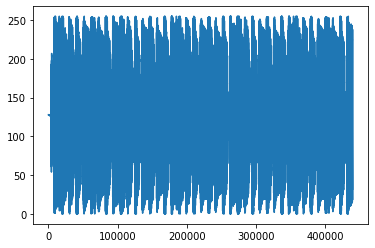

In [11]:
transformed = torchaudio.transforms.MuLawEncoding()(waveform)

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

Now the data type is 64 bit integers

In [12]:
transformed.dtype

torch.int64